In [1]:
!python3 --version

Python 3.10.14


In [2]:
!pip install pyqubo


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install openjij jijmodeling_transpiler


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip show pyqubo

Name: pyqubo
Version: 1.4.0
Summary: PyQUBO allows you to create QUBOs or Ising models from mathematical expressions.
Home-page: https://github.com/recruit-communications/pyqubo
Author: Recruit Co., Ltd.
Author-email: rco_pyqubo@ml.cocorou.jp
License: Apache 2.0
Location: /Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages
Requires: Deprecated, dimod, dwave-neal, numpy, six
Required-by: jijmodeling-transpiler


In [5]:
from pyqubo import Array, Placeholder, solve_ising, Constraint, SubH, Model, Binary
import re, random, math
import numpy as np
import openjij as oj
import time 

タスクの処理時間を優先する場合を使うときはリソースコストを優先とする場合はコメントアウトする(逆も同じである)

データ保存・参照したい場合はデータ名に気をつけて

ver1と比較したい場合はタスク長の大きさは合わせる必要があるかな

In [6]:
def assign_resource_num(resource):
    resource_num = {}
    cnt = 0
    for i in resource:
        for j in resource[i]:
            resource_num[j] = cnt
            cnt += 1
    return resource_num

In [7]:
resource_m = {'R0': ['m11', 'm12'], 'R1': ['m21', 'm22'], 'R2': ['m31', 'm32']}
machine_processing_time = {'m11': 1, 'm12': 2, 'm21': 3, 'm22': 1, 'm31': 1, 'm32': 3}
machine_cost = {'m11': 10, 'm12': 14, 'm21': 13, 'm22': 10, 'm31': 12, 'm32': 10}

resource_num = assign_resource_num(resource_m)

resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [8]:
# スケジューリング問題のjobリソースを生成
def generate_jobs_and_resources(num_jobs, seed=None):
    resource_t = {'R0': [], 'R1': [], 'R2': []}
    place = []
    job = []
    job_tasks = {}  # タスク長を格納する辞書

    # シードを設定（指定された場合のみ）
    if seed is not None:
        random.seed(seed)

    for i in range(1, num_jobs + 1):
        t11 = f't{i}1'
        t12 = f't{i}2'
        t13 = f't{i}3'

        job.append([t11, t12, t13])

        resource_t['R0'].append(t11)
        resource_t['R1'].append(t12)
        resource_t['R2'].append(t13)

        place.append([f'p{i}1', f'p{i}2', f'p{i}3', f'p{i}4'])

        # 各タスクに1から10の範囲でランダムなタスク長を割り当てる
        job_tasks[t11] = random.randint(1, 10)  # t11にランダムなタスク長を割り当て
        job_tasks[t12] = random.randint(1, 10)  # t12にランダムなタスク長を割り当て
        job_tasks[t13] = random.randint(1, 10)  # t13にランダムなタスク長を割り当て

    return resource_t, place, job, job_tasks

In [9]:
# R0, R1, R2ごとにマシンごとのタスク処理時間を保存する関数
def calculate_task_matrix(job_tasks, resource_t, resource_m, machine_processing_time):
    matrices = {}

    # 各リソースごとにマシンごとの行列を作成
    for resource, tasks in resource_t.items():
        machines = resource_m[resource]  # リソースに対応するマシンリスト
        num_tasks = len(tasks)
        num_machines = len(machines)

        # 結果を保存する行列（タスク数×マシン数）
        result_matrix = np.zeros((num_tasks, num_machines))

        for task_idx, task in enumerate(tasks):
            task_duration = job_tasks[task]  # タスクの処理時間を取得

            for machine_idx, machine in enumerate(machines):
                machine_time = machine_processing_time[machine]  # マシンの処理時間を取得

                # タスク長をマシン処理時間で割る
                result_matrix[task_idx, machine_idx] = task_duration / machine_time

        # リソースごとに行列を保存
        matrices[resource] = result_matrix

    return matrices

In [10]:
def calculate_machine_cost_matrix(resource_t, resource_m, machine_cost):
    matrices = {}

    # 各リソースごとにマシンごとの行列を作成
    for resource, tasks in resource_t.items():
        machines = resource_m[resource]  # リソースに対応するマシンリスト
        num_tasks = len(tasks)
        num_machines = len(machines)

        # 結果を保存する行列（タスク数×マシン数）
        result_matrix = np.zeros((num_tasks, num_machines))

        for machine_idx, machine in enumerate(machines):
            machine_cost_value = machine_cost[machine]  # マシンのコストを取得

            # 全タスクに対して同じマシンコストを適用
            result_matrix[:, machine_idx] = machine_cost_value

        # リソースごとに行列を保存
        matrices[resource] = result_matrix

    return matrices

In [11]:
num_jobs = 8 #jobの数
resource_t, place, job, job_tasks = generate_jobs_and_resources(num_jobs, seed=42)
limit_time = 30 #制限時刻

In [12]:
job_tasks = {'t11': 2,
 't12': 1,
 't13': 5,
 't21': 4,
 't22': 4,
 't23': 3,
 't31': 2,
 't32': 2,
 't33': 7,
 't41': 1,
 't42': 1,
 't43': 2,
 't51': 4,
 't52': 4,
 't53': 1,
 't61': 4,
 't62': 7,
 't63': 4,
 't71': 8,
 't72': 5,
 't73': 1,
 't81': 9,
 't82': 7,
 't83': 4}

In [13]:
job_tasks

{'t11': 2,
 't12': 1,
 't13': 5,
 't21': 4,
 't22': 4,
 't23': 3,
 't31': 2,
 't32': 2,
 't33': 7,
 't41': 1,
 't42': 1,
 't43': 2,
 't51': 4,
 't52': 4,
 't53': 1,
 't61': 4,
 't62': 7,
 't63': 4,
 't71': 8,
 't72': 5,
 't73': 1,
 't81': 9,
 't82': 7,
 't83': 4}

In [14]:
transition_num = {}
cnt = 0
for i in job:
    for j in i:
        transition_num[j] = cnt
        cnt += 1
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14,
 't61': 15,
 't62': 16,
 't63': 17,
 't71': 18,
 't72': 19,
 't73': 20,
 't81': 21,
 't82': 22,
 't83': 23}

In [15]:
# 各リソースごとにタスクの処理時間をマシンで割った行列を計算
task_matrices = calculate_task_matrix(job_tasks, resource_t, resource_m, machine_processing_time)

In [16]:
# 各リソースごとにタスクの処理時間をマシンで割った行列を計算
cost_matrices = calculate_machine_cost_matrix(resource_t, resource_m, machine_processing_time)

In [17]:
def assign_tasks_to_machines(best_solution, task_number, num_tasks):
    schedule_dict = {}  # タスクとマシンの割り当てを格納する辞書

    for idx, value in best_solution.items():
        if value == 1:  # 値が1のときのみ格納
            machine_index = idx // num_tasks  # マシンインデックスを計算
            task_index = idx % num_tasks      # タスクインデックスを計算
            task_name = f't{task_index + 1}{task_number}'  # タスク番号はtask_number
            
            # マシン名を生成
            machine_name = f'm{task_number}{machine_index + 1}'
            
            # タスクとマシンの対応を辞書に保存
            schedule_dict[task_name] = machine_name

    return schedule_dict

In [18]:
# 各トランジションの処理時間の最大・最小値を求める関数
def calculate_time_ranges(job, job_tasks, task_resources, machine_processing_time, total_time):
    range_trantision_ptime = {}

    # 各ジョブに対して処理を行う
    for idx, j in enumerate(job):
        # 最後のタスクの上限は total_time になる
        ub = total_time
        
        for i in reversed(range(len(j))):  # タスクを逆順に処理
            task = j[i]

            # 下限（lb）の計算: 現在のタスクまでの合計処理時間（小数点を切り上げ）
            lb = 0
            if i != 0:
                lb = sum([math.ceil(job_tasks[j[k]] / machine_processing_time[task_resources[j[k]]]) for k in range(i)])

            # 上限（ub）の計算: 次のタスクの上限から現在のタスクの処理時間を引く
            if i < len(j) - 1:  # 最後のタスクでない場合
                ub -= math.ceil(job_tasks[task] / machine_processing_time[task_resources[task]])

            # 計算結果を保存
            range_trantision_ptime[task] = [lb, ub]

    # 指定された順序でタスクを整列
    ordered_keys = sorted(range_trantision_ptime.keys(), key=lambda x: (int(x[1:]), int(x[2:])))
    ordered_ranges = {key: range_trantision_ptime[key] for key in ordered_keys}

    return ordered_ranges

## マシンリソースの割り当ての目的関数

In [19]:
import jijmodeling as jm
import jijmodeling_transpiler as jmt

# 問題の定義
problem = jm.Problem("Task Scheduling")

# プレースホルダーとバイナリ変数の定義
M = task_matrices['R0'].ndim  # マシンの数
T = task_matrices['R0'].shape[0]  # タスクの数
a = jm.Placeholder("a", ndim=2)  # タスク長を表すプレースホルダー (M, T)
x = jm.BinaryVar("x", shape=(M, T))  # バイナリ変数 (M, T)
t = jm.Element("t", (0, T))
m = jm.Element("m", (0, M))

# エネルギー関数を問題に追加
problem += jm.sum((m,m!=0),(jm.sum(t, a[0, t] * x[0, t]) - jm.sum(t, a[m, t] * x[m, t])) ** 2)

# 各タスクtは必ず1つのマシンmに割り当てられる
problem += jm.Constraint("task_assignment", jm.sum(m, x[m, t]) == 1, forall=t)


In [20]:
problem

In [21]:
def process_optimization(matrix_name, matrix_type='task'):
    if matrix_type == 'task':
        matrix_data = task_matrices[matrix_name].T
    elif matrix_type == 'cost':
        matrix_data = cost_matrices[matrix_name].T
    else:
        raise ValueError("matrix_type must be 'task' or 'cost'")
    
    instance_data = {
        "a": matrix_data
    }
    
    # compile the model using jijmodeling_transpiler
    compiled_model = jmt.core.compile_model(problem, instance_data, {})

    # QUBO形式に変換
    pubo_builder = jmt.core.pubo.transpile_to_pubo(
        compiled_model=compiled_model, 
        relax_method=jmt.core.pubo.RelaxationMethod.AugmentedLagrangian
    )

    # QUBOと定数項を取得
    qubo, const = pubo_builder.get_qubo_dict(multipliers={})
    
    return pubo_builder, compiled_model, qubo, const

## 処理時間優先としたマシンリソースの割当て

In [22]:
R0_task_pubo_builder,R0_task_compiled_model,R0_task_qubo,R0_const = process_optimization('R0','task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R0_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R0_task_pubo_builder, R0_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1], -7.99305556, 1),
           ([1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1], -7.99826389, 1),
           ([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], -7.99826389, 1),
           ([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1], -7.99826389, 1),
           ([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1], -7.99826389, 1),
           ([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0], -7.78993056, 1),
           ([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1], -7.82638889, 1),
           ([1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1], -7.99826389, 1),
           ([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0], -7.95659722, 1),
           ([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0], -7.95659722, 1),
           ([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1], -7.91493056, 1),
           ([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1], -7.99305556, 1),
           ([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 

In [23]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 1
x[0, 1] = 0
x[0, 2] = 0
x[0, 3] = 0
x[0, 4] = 0
x[0, 5] = 0
x[0, 6] = 0
x[0, 7] = 1
x[1, 0] = 0
x[1, 1] = 1
x[1, 2] = 1
x[1, 3] = 1
x[1, 4] = 1
x[1, 5] = 1
x[1, 6] = 1
x[1, 7] = 0


In [24]:
schedule_task_dict = assign_tasks_to_machines(best_solution,1,num_tasks)
schedule_task_dict

{'t11': 'm11',
 't81': 'm11',
 't21': 'm12',
 't31': 'm12',
 't41': 'm12',
 't51': 'm12',
 't61': 'm12',
 't71': 'm12'}

In [25]:
R1_task_pubo_builder,R1_task_compiled_model,R1_task_qubo,R1_task_const = process_optimization('R1', 'task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R1_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R1_task_pubo_builder, R1_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1], -7.97165533, 1),
           ([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0], -7.98979592, 1),
           ([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0], -7.99886621, 1),
           ([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], -7.98979592, 1),
           ([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0], -7.86281179, 1),
           ([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1], -7.80839002, 1),
           ([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0], -7.94444444, 1),
           ([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], -7.6723356 , 1),
           ([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], -7.6723356 , 1),
           ([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0], -7.97165533, 1),
           ([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0], -7.86281179, 1),
           ([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], -7.98979592, 1),
           ([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 

In [26]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 0
x[0, 1] = 1
x[0, 2] = 1
x[0, 3] = 1
x[0, 4] = 1
x[0, 5] = 0
x[0, 6] = 1
x[0, 7] = 1
x[1, 0] = 1
x[1, 1] = 0
x[1, 2] = 0
x[1, 3] = 0
x[1, 4] = 0
x[1, 5] = 1
x[1, 6] = 0
x[1, 7] = 0


In [27]:
schedule_task_dict2 = assign_tasks_to_machines(best_solution,2,num_tasks)
schedule_task_dict2

{'t22': 'm21',
 't32': 'm21',
 't42': 'm21',
 't52': 'm21',
 't72': 'm21',
 't82': 'm21',
 't12': 'm22',
 't62': 'm22'}

In [28]:
R2_task_pubo_builder,R2_task_compiled_model,R2_task_qubo,R2_task_const = process_optimization('R2', 'task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R2_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R2_task_pubo_builder, R2_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1], -7.87142857, 1),
           ([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], -7.96031746, 1),
           ([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1], -7.92222222, 1),
           ([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1], -7.96031746, 1),
           ([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1], -7.80793651, 1),
           ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1], -7.98571429, 1),
           ([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1], -7.87142857, 1),
           ([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1], -7.96031746, 1),
           ([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1], -7.9984127 , 1),
           ([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1], -7.96031746, 1),
           ([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1], -7.98571429, 1),
           ([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1], -7.73174603, 1),
           ([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 

In [29]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 0
x[0, 1] = 0
x[0, 2] = 0
x[0, 3] = 1
x[0, 4] = 0
x[0, 5] = 0
x[0, 6] = 1
x[0, 7] = 1
x[1, 0] = 1
x[1, 1] = 1
x[1, 2] = 1
x[1, 3] = 0
x[1, 4] = 1
x[1, 5] = 1
x[1, 6] = 0
x[1, 7] = 0


In [30]:
schedule_task_dict3 = assign_tasks_to_machines(best_solution,3,num_tasks)
schedule_task_dict3

{'t43': 'm31',
 't73': 'm31',
 't83': 'm31',
 't13': 'm32',
 't23': 'm32',
 't33': 'm32',
 't53': 'm32',
 't63': 'm32'}

In [31]:
# 辞書をまとめる
combined_task_schedule = {**schedule_task_dict, **schedule_task_dict2, **schedule_task_dict3}

# タスク名を数値に変換してソート
sorted_task_schedule = dict(sorted(combined_task_schedule.items(), key=lambda x: (int(x[0][1:]))))
sorted_schedule = sorted_task_schedule
sorted_task_schedule

{'t11': 'm11',
 't12': 'm22',
 't13': 'm32',
 't21': 'm12',
 't22': 'm21',
 't23': 'm32',
 't31': 'm12',
 't32': 'm21',
 't33': 'm32',
 't41': 'm12',
 't42': 'm21',
 't43': 'm31',
 't51': 'm12',
 't52': 'm21',
 't53': 'm32',
 't61': 'm12',
 't62': 'm22',
 't63': 'm32',
 't71': 'm12',
 't72': 'm21',
 't73': 'm31',
 't81': 'm11',
 't82': 'm21',
 't83': 'm31'}

In [32]:
range_trantision_ptime = calculate_time_ranges(job, job_tasks, sorted_task_schedule, machine_processing_time, limit_time)

range_trantision_ptime

{'t11': [0, 27],
 't12': [2, 29],
 't13': [3, 30],
 't21': [0, 26],
 't22': [2, 28],
 't23': [4, 30],
 't31': [0, 28],
 't32': [1, 29],
 't33': [2, 30],
 't41': [0, 28],
 't42': [1, 29],
 't43': [2, 30],
 't51': [0, 26],
 't52': [2, 28],
 't53': [4, 30],
 't61': [0, 21],
 't62': [2, 23],
 't63': [9, 30],
 't71': [0, 24],
 't72': [4, 28],
 't73': [6, 30],
 't81': [0, 18],
 't82': [9, 27],
 't83': [12, 30]}

## リソースコストを優先とした割り当て

In [33]:
# R0_cost_pubo_builder,R0_cost_compiled_model,R0_cost_qubo,R0_cost_const = process_optimization('R0', 'cost')

# # set sampler_op
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R0_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R0_cost_pubo_builder, R0_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [34]:
# best_solution = response.first.sample

# # マシン数とタスク数を設定
# num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
# num_tasks = num_jobs                     # タスク数を設定

# # 結果を表示
# for idx, value in best_solution.items():
#     machine_index = idx // num_tasks  # マシンインデックスを計算
#     task_index = idx % num_tasks       # タスクインデックスを計算
#     print(f"x[{machine_index}, {task_index}] = {value}")

In [35]:
schedule_cost_dict = assign_tasks_to_machines(best_solution,1,num_tasks)
schedule_cost_dict

{'t41': 'm11',
 't71': 'm11',
 't81': 'm11',
 't11': 'm12',
 't21': 'm12',
 't31': 'm12',
 't51': 'm12',
 't61': 'm12'}

In [36]:
# R1_cost_pubo_builder,R1_cost_compiled_model,R1_cost_qubo,R0_cost_const = process_optimization('R1', 'cost')

# # set sampler
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R1_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R1_cost_pubo_builder, R1_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [37]:
# best_solution = response.first.sample

# # マシン数とタスク数を設定
# num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
# num_tasks = num_jobs                     # タスク数を設定

# # 結果を表示
# for idx, value in best_solution.items():
#     machine_index = idx // num_tasks  # マシンインデックスを計算
#     task_index = idx % num_tasks       # タスクインデックスを計算
#     print(f"x[{machine_index}, {task_index}] = {value}")

In [38]:
# schedule_cost_dict2 = assign_tasks_to_machines(best_solution,2,num_tasks)
# schedule_cost_dict2

In [39]:
# R2_cost_pubo_builder,R2_cost_compiled_model,R2_cost_qubo,R0_cost_const = process_optimization('R2', 'cost')

# # set sampler
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R1_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R2_cost_pubo_builder, R2_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [40]:
# schedule_cost_dict3 = assign_tasks_to_machines(best_solution,3,num_tasks)
# schedule_cost_dict3

In [41]:
# # 辞書をまとめる
# combined_cost_schedule = {**schedule_cost_dict, **schedule_cost_dict2, **schedule_cost_dict3}

# # タスク名を数値に変換してソート
# sorted_cost_schedule = dict(sorted(combined_cost_schedule.items(), key=lambda x: (int(x[0][1:]))))
# sorted_schedule = sorted_cost_schedule
# sorted_cost_schedule

In [42]:
# range_trantision_ptime = calculate_time_ranges(job, job_tasks, sorted_cost_schedule, machine_processing_time, limit_time)

# range_trantision_ptime

## バイナリ変数

In [43]:
t_num = len(transition_num)
r_num = len(resource_num)
x = Array.create('x', (limit_time, t_num), 'BINARY')  # binaryの宣言 

## H_firing

In [44]:
H_firing = 0.0
for idx, j in enumerate(job):
    for i in range(len(j)):  # 各タスクについて
        sigma_h_firing = 0.0
        
        # タスクの実行可能範囲を取得
        start_time = range_trantision_ptime[j[i]][0]
        end_time = range_trantision_ptime[j[i]][1]

        # 各タイムステップにおけるバイナリ変数を合計;;
        for k in range(start_time, end_time):
            t = transition_num[j[i]]
            sigma_h_firing += x[k,t]
            
        H_firing += Constraint((1-sigma_h_firing)**2,label="one_fired_t{}{}".format(idx+1,i+1))

## H_conflict

In [45]:
H_conflict = 0.0
for i in range(len(job[0])):
    for j1 in range(len(job)):
        t1 = transition_num[job[j1][i]]
        for j2 in range(len(job)):
            t2 = transition_num[job[j2][i]]
            if j1 != j2:
                lb = range_trantision_ptime[job[j1][i]][0]  # t1の下限
                ub = range_trantision_ptime[job[j1][i]][1]  # t1の上限

                # j1 のタスク処理時間を計算
                task_length = job_tasks[job[j1][i]]
                processing_time = math.ceil(task_length / machine_processing_time[sorted_schedule[job[j1][i]]])

                for k1 in range(lb, limit_time+1):
                    fd = k1 + processing_time  # t1の終了時刻

                    for k2 in range(k1, min(fd,limit_time)): #j2の下限と上限
                        
                        if sorted_schedule[job[j1][i]] == sorted_schedule[job[j2][i]]:  # 同じマシンリソースを使う
                            H_conflict += Constraint((x[k1,t1])*(x[k2,t2]), label="conflict{}{}".format(t1,t2))



## H_precedence

In [46]:
H_precedence = 0.0
for idx, j in enumerate(job):
    for i in range(len(j) - 1):
        lb = range_trantision_ptime[j[i]][0]
        ub = range_trantision_ptime[j[i]][1]
        # 現在のタスクの長さを取得 (job[j][i]がタスク識別子)
        task_length = job_tasks[job[idx][i]] # 現在のタスクの長さ
        # 現在のタスクに関連するリソースの処理時間を取得
        processing_time = math.ceil(task_length / machine_processing_time[sorted_schedule[job[idx][i]]])
        
        t1 = transition_num[j[i]]
        t2 = transition_num[j[i + 1]]
        for k1 in range(0, limit_time):
            fd = k1 + processing_time
            for k2 in range(min(fd,limit_time)):
                H_precedence += Constraint((x[k1,t1])*(x[k2,t2]), label="precedence{}{}{}{}".format(k1,t1,k2,t2))

## H_resourceCost

In [47]:
H_resourceCost = 0.0
for j in range(len(job)):
    for i in range(len(job[j])):
        # リソースと関連するパラメータの取得
        resource = sorted_schedule[job[j][i]]
        resource_cost = machine_cost[resource]
        task_length = job_tasks[job[j][i]]
        processing_time = math.ceil(task_length / machine_processing_time[sorted_schedule[job[j][i]]])
        
        # 時間範囲の設定
        lb = range_trantision_ptime[job[j][i]][0]
        ub = range_trantision_ptime[job[j][i]][1]
        t = transition_num[job[j][i]]
        
        for k in range(lb, ub):            
            H_resourceCost += resource_cost * processing_time * x[k, t]

## H_waitingTime

In [48]:
H_waitingTime = 0.0
for j in range(len(job)):
    for i in range(len(job[j]) - 1):
        #後のタスク
        lb1 = range_trantision_ptime[job[j][i + 1]][0]
        ub1 = range_trantision_ptime[job[j][i + 1]][1]
        t1 = transition_num[job[j][i + 1]]
        #前のタスク
        lb2 = range_trantision_ptime[job[j][i]][0]
        ub2 = range_trantision_ptime[job[j][i]][1]
        t2 = transition_num[job[j][i]]
        
        for k1 in range(lb1, ub1):
            for k2 in range(lb2, ub2):
                task_length = job_tasks[job[j][i]]  # 現在のタスクの長さ
                
                # それぞれのタスクに必要な処理時間を計算
                processing_time = math.ceil(task_length / machine_processing_time[sorted_schedule[job[j][i]]])
                
                # 待ち時間の計算
                waiting_time = k1 - (k2 + processing_time)
                
                if waiting_time >= 0:
                    # 目的関数に追加
                    H_waitingTime += waiting_time * x[k2,t2] * x[k1,t1]

## ベイズ最適化

In [ ]:
import pandas as pd
import optuna
import openjij as oj
import re

A = Placeholder("A")
B = Placeholder("B")
C = Placeholder("C")

# 結果を保存するためのリスト
results = []
decoded_results = []  # sort_ans を保存するためのリスト

def extractVariable(s):  
    literal = re.split('[\[\]]', s)
    while '' in literal:
        literal.remove('')       
    return literal


def objective(trial):
    
    A = trial.suggest_float("A", 700, 2500)
    B = trial.suggest_float("B", 150, 500)
    C = trial.suggest_float("C", 150, 500)
    E = trial.suggest_float("E", 1, 30)

    H = (
        SubH(A * H_firing, "SubH1") +
        SubH(B * H_conflict, "SubH2") +
        SubH(C * H_precedence, "SubH3") +
        SubH(H_resourceCost, "SubH4") +
        SubH(E * H_waitingTime, "SubH5")
    )
    
    model = H.compile()
    # feed_dict = {"A": 699, "B": 192, "C": 241, "E": E}
    feed_dict = {"A": A, "B": B, "C": C, "E": E}
    bqm = model.to_bqm(feed_dict=feed_dict)
    
    # アニーリング回数
    num_iterations = 100

    # QUBOを辞書形式に変換
    qubo_dict = bqm.to_qubo()[0]

    sampler = oj.SASampler()
    response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

    # サンプリング結果をデコード
    decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

    # 最良のサンプルを選択
    best_sample = min(decoded_samples, key=lambda x: x.energy)

    # サンプルから値が1の変数を抽出
    keys = [k for k, v in best_sample.sample.items() if v == 1]
    
    ans = []

    for k in keys:
        ans.append(extractVariable(k))

    sort_ans = list(range(len(ans)))

    for i in ans:
        sort_ans[int(i[2])] = i

    # sort_ans をリストに保存
    decoded_results.append({
        "trial": trial.number,
        "energy": best_sample.energy,
        "sort_ans": sort_ans  # ソートされたデコード結果
    })

    # feasibleかどうかを確認
    feasible = all(best_sample.subh.get(i, float('inf')) == 0 for i in ['SubH1', 'SubH2', 'SubH3'])

    # 他の結果を保存
    results.append({
        "trial": trial.number,
        "num_qubits": len(bqm.variables),
        "energy": best_sample.energy,
        "feasible": feasible,
        "SubH1": best_sample.subh['SubH1'],
        "SubH2": best_sample.subh['SubH2'],
        "SubH3": best_sample.subh['SubH3'],
        "SubH4": best_sample.subh['SubH4'],
        "SubH5": best_sample.subh['SubH5'],
        "A": A,
        "B": B,
        "C": C,
        "E": E
    })

    # feasible でなければペナルティを返す
    if not feasible:
        penalty_value = 1000  # ペナルティ値を具体的に設定
        return penalty_value, penalty_value


    # feasible であれば SubH4 と SubH5 の値を返す
    return best_sample.subh['SubH4'], best_sample.subh['SubH5']

/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [ ]:
from optuna.samplers import TPESampler  # ここを追加

# Optuna の最適化を実行
sampler = TPESampler(multivariate=True, group=True, prior_weight=1.0, seed=1234)
study = optuna.create_study(directions=('minimize', 'minimize'), sampler=sampler)
study.optimize(objective, n_trials=100)

# 結果をデータフレームに変換
df_results = pd.DataFrame(results)
df_decoded = pd.DataFrame(decoded_results)

# 結果をCSVファイルとして保存
df_results.to_csv("./search/job8/exam/optimization_results_job8_task_1.csv", index=False)
df_decoded.to_csv("./search/job8/exam/decoded_results_job8_task_1.csv", index=False)

/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:330: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-02-06 10:47:34,795] A new study created in memory with name: no-name-8b176d97-5fa1-4c62-b745-3f192e55259c
[I 2025-02-06 10:47:39,591] Trial 0 finished with values: [1000.0, 1000.0] and parameters: {'A': 1044.735010682006, 'B': 367.7380698639412, 'C': 303.20470865249007, 'E': 23.775398927699307}. 
[I 2025-02-06 10:47:44,420] Trial 1 finished with values: [1000.0, 1000.0] and parameters: {'A': 2103.9564546138463, 'B': 245.40741184892457, 'C': 246.76248930008384, 'E': 24.254293148515558}. 
[I 2025-02-06 10:47:49,316] Trial 2 finis

## データをcsvに保存する

In [51]:
# import csv
# import os
# from datetime import datetime

# now = datetime.now()
# timestamp = now.strftime('%Y-%m-%d')

# # 保存するファイル名
# csv_filename = f'./search/t_30/1217/{timestamp}_patt1_job{num_jobs}.csv' #任意のファイル名

# # CSVファイルが存在するかどうかを確認
# file_exists = os.path.isfile(csv_filename)

# constraint_error = best_sample.constraints(only_broken=True)
# feasible = 0 if is_feasible else constraint_error 
# #制約違反起こしてない場合もある、そのときはサブハミルトニアンが0ではない場合があるので出力する様にしている

# # データをリストのリストとして準備
# # data = [[num_iterations, machine_cost, processing_time, resource_cost, wating_time, feasible]]
# data = [[num_iterations, resource_cost, waiting_time, feasible]]

# # ファイルが存在しない場合はヘッダーを追加
# if not file_exists:
#     with open(csv_filename, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         # writer.writerow(['iteration', 'machine_cost', 'processing_time', 'resource_cost', 'wating_time','feasible'])
#         writer.writerow(['iteration', 'resource_cost', 'waiting_time','feasible'])
#         writer.writerows(data)
# else:
#     # ファイルが存在する場合は追記
#     with open(csv_filename, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)

## plot(以前使ったやつ、もう使わないかな？)

In [52]:
# import pandas as pd
# import re
# import glob

# # ファイルパスを取得
# file_paths = glob.glob("./search/t_30/1107/2024-11-07_patt*_job15.csv")
# # file_paths = [f for f in file_paths if re.search(r'patt([1-6])_job15\.csv$', f)] #processing_time
# file_paths = [f for f in file_paths if re.search(r'patt([7-9]|1[0-2])_job15\.csv$', f)] #resourcecost

# file_paths.sort(key=lambda x: int(re.search(r'patt(\d+)', x).group(1)))

# # 出力用のリスト
# output = []

# # 各ファイルに対して処理
# for file_path in file_paths:
#     # データを読み込む
#     data = pd.read_csv(file_path)

#     # ファイル名から「patt」の番号を抽出
#     # patt_number = re.search(r'patt([1-6])', file_path).group(1) #processing_time
#     patt_number = re.search(r'patt([7-9]|1[0-2])', file_path).group(1) #resourcecost


#     # feasibleを文字列型に変換してフィルタ
#     data['feasible'] = data['feasible'].astype(str)
#     feasible_zero = data[data['feasible'] == '0']

#     # 各列の平均を計算
#     iteration_mean = feasible_zero['iteration'].mean()
#     resource_cost_mean = feasible_zero['resource_cost'].mean()
#     waiting_time_mean = feasible_zero['waiting_time'].mean()

#     # 1行分の辞書を追加
#     output.append({
#         'iteration': int(iteration_mean),
#         'mean_resource_cost': resource_cost_mean,
#         'mean_waiting_time': waiting_time_mean,
#         'label': f"{patt_number}_{int(iteration_mean)}"
#     })

# # 出力をデータフレーム化
# output_df = pd.DataFrame(output)
# output_df


In [53]:
# output_df.to_csv('./search/t_30/1107/processing_time.csv', index=False)

In [54]:
# output_df.to_csv('./search/t_30/1107/resourcecost.csv', index=False)

In [55]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # データを読み込む
# df = pd.read_csv('./search/t_30/1107/resourcecost.csv')

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 横軸を 'label' 列のデータで、縦軸を 'mean_resource_cost' に設定してプロット
# x_indices = np.arange(len(df['label']))

# ax1.plot(
#     x_indices, 
#     df['mean_resource_cost'], 
#     marker='o', linestyle='-', color='b', 
#     label='Mean Resource Cost'
# )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 右のY軸を 'mean_waiting_time' に設定してプロット
# ax2.plot(
#     x_indices, 
#     df['mean_waiting_time'], 
#     marker='x', linestyle='--', color='r', 
#     label='Mean Waiting Time'
# )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('Parameter E')
# ax1.set_ylabel('Resource Cost')
# ax2.set_ylabel('Waiting Time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()

In [56]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # 読み込むCSVファイルのリスト
# csv_files = [
#     './search/t_30/1107/processing_time.csv',
#     './search/t_30/1107/resourcecost.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_1_to_6.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_7_to_12.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_13_to_18.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_19_to_24.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_25_to_30.csv'
# ]

# # 凡例のラベルをDの値に対応させる
# legend_labels = ['fast', 'eco', 'D=1', 'D=5', 'D=8', 'D=10', 'D=13']

# # カラーマップを作成（viridisカラーマップを使用）
# colors = plt.cm.viridis(np.linspace(0, 1, len(csv_files)))

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax1.plot(
#         x_indices, 
#         final_df['mean_resource_cost'], 
#         marker='o', linestyle='-', color=colors[i], 
#         label=legend_labels[i]
#     )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax2.plot(
#         x_indices, 
#         final_df['mean_waiting_time'], 
#         marker='x', linestyle='--', color=colors[i], 
#         label=legend_labels[i]
#     )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('parameter E')
# ax1.set_ylabel('resource cost')
# ax2.set_ylabel('waiting time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time by Pattern and Iteration=100')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()


## ガントチャート

In [38]:
import pandas as pd
result1 = pd.read_csv("./search/job7/exam/optimization_results_job7_cost_5.csv")
result2 = pd.read_csv("./search/job7/exam/decoded_results_job7_cost_5.csv")

In [39]:
# result1 をデータフレームに変換
df = pd.DataFrame(result1)

# feasible が True の行だけ抽出
feasible_df = df[df["feasible"] == True]

# 抽出結果を表示
print(feasible_df)

    trial  num_qubits       energy  feasible  SubH1  SubH2  SubH3  SubH4  \
25     25         540   667.553728      True    0.0    0.0    0.0  436.0   
92     92         540  1178.075655      True    0.0    0.0    0.0  436.0   

         SubH5            A           B           C          E  
25  231.553728   549.514719  226.967098  222.835803   9.648072  
92  742.075655  1108.102734  249.508206  270.162426  13.742142  


In [40]:
print(feasible_df['SubH4'])

25    436.0
92    436.0
Name: SubH4, dtype: float64


In [41]:
print(feasible_df['SubH5'] / feasible_df['E'])

25    24.0
92    54.0
dtype: float64


In [28]:
feasible_df.shape

(0, 13)

In [62]:
sort_ans = result2["sort_ans"][23]

In [63]:
sort_ans

"[['x', '5', '0'], ['x', '17', '1'], ['x', '19', '2'], ['x', '17', '3'], ['x', '21', '4'], ['x', '29', '5'], ['x', '1', '6'], ['x', '4', '7'], ['x', '13', '8'], ['x', '15', '9'], ['x', '25', '10'], ['x', '28', '11'], ['x', '19', '12'], ['x', '27', '13'], ['x', '14', '14'], ['x', '3', '15'], ['x', '6', '16'], ['x', '26', '17']]"

In [64]:
import ast
sort_ans = ast.literal_eval(sort_ans)
sort_ans

[['x', '5', '0'],
 ['x', '17', '1'],
 ['x', '19', '2'],
 ['x', '17', '3'],
 ['x', '21', '4'],
 ['x', '29', '5'],
 ['x', '1', '6'],
 ['x', '4', '7'],
 ['x', '13', '8'],
 ['x', '15', '9'],
 ['x', '25', '10'],
 ['x', '28', '11'],
 ['x', '19', '12'],
 ['x', '27', '13'],
 ['x', '14', '14'],
 ['x', '3', '15'],
 ['x', '6', '16'],
 ['x', '26', '17']]

In [65]:
resource_num = assign_resource_num(resource_m)
resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

Task t11: Processing time = 2
Task t12: Processing time = 1
Task t13: Processing time = 2
Task t21: Processing time = 2
Task t22: Processing time = 2
Task t23: Processing time = 3
Task t31: Processing time = 2
Task t32: Processing time = 2
Task t33: Processing time = 3
Task t41: Processing time = 1
Task t42: Processing time = 1
Task t43: Processing time = 1
Task t51: Processing time = 4
Task t52: Processing time = 2
Task t53: Processing time = 1
Task t61: Processing time = 2
Task t62: Processing time = 7
Task t63: Processing time = 2


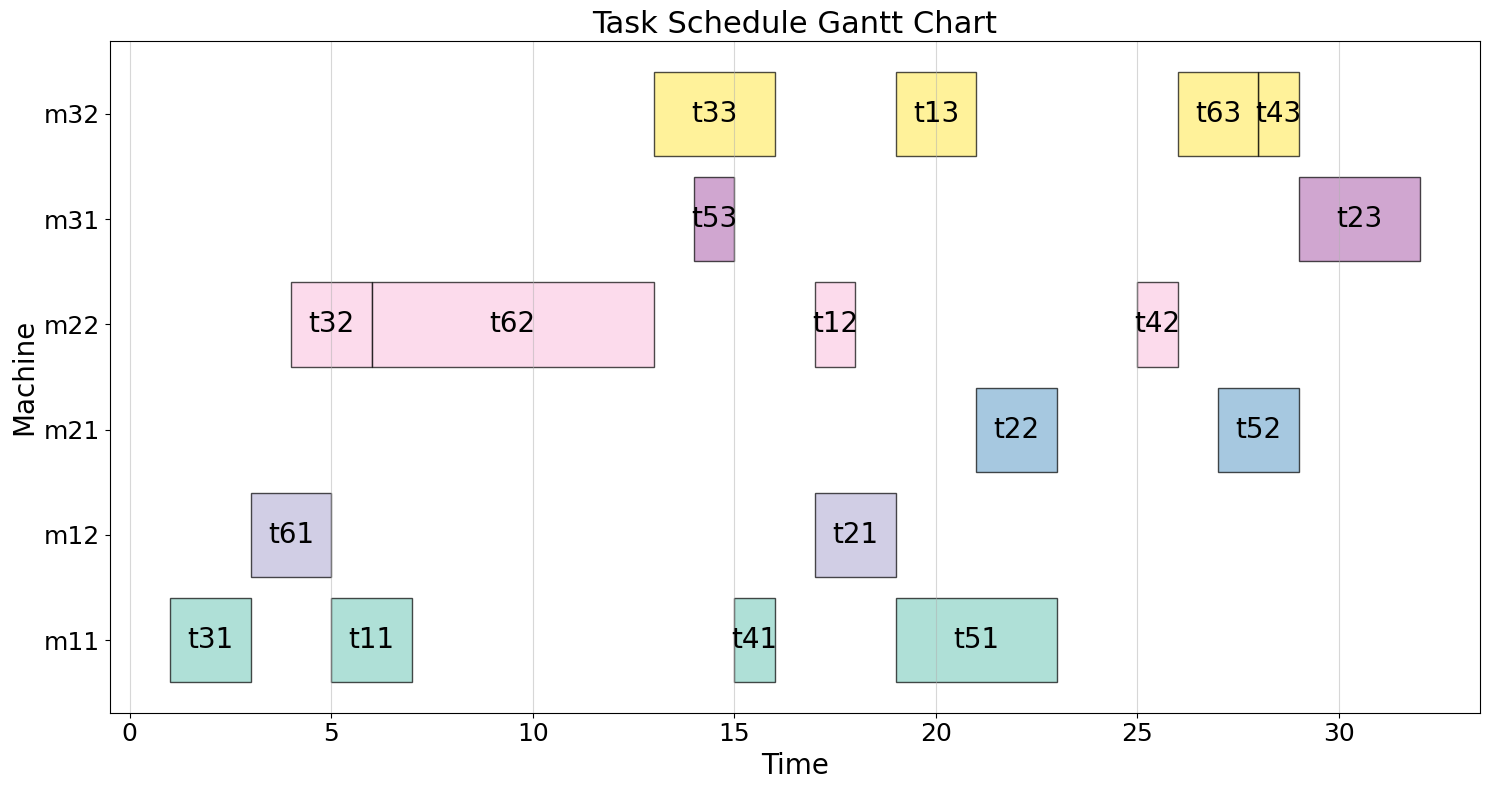

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import math

def create_gantt_chart(transition_num, sorted_task_schedule, sort_ans, job_tasks, machine_processing_time, job):
    # マシンのユニークリストを取得
    machines = sorted(list(set(sorted_task_schedule.values())))
    machine_to_idx = {machine: idx for idx, machine in enumerate(machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = sorted_task_schedule[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # ジョブごとに異なる色を設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(job)))  # ジョブ数に応じたカラーマップ
    job_colors = {tuple(tasks): color for tasks, color in zip(job, colors)}  # ジョブと色を対応付け
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(machines)))
    machine_colors = dict(zip(machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスク名が属するジョブを見つけて色を設定
        task_color = None
        for tasks in job:
            if task in tasks:
                task_color = job_colors[tuple(tasks)]
                break
            
        if task_color is None:
            raise ValueError(f"Task {task} not found in job list")
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示（フォントサイズ変更）
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=20)  # ← フォントサイズをさらに大きく
    
    # グラフの装飾（フォントサイズ変更）
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines, fontsize=18)  # y軸のフォントサイズを大きく
    ax.set_xlabel('Time', fontsize=20)  # x軸ラベルのフォントサイズを大きく
    ax.set_ylabel('Machine', fontsize=20)  # y軸ラベルのフォントサイズを大きく
    ax.set_title('Task Schedule Gantt Chart', fontsize=22)  # タイトルのフォントサイズを大きく
    
    # x軸の目盛フォントサイズを変更
    plt.xticks(fontsize=18)

    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.5)  # グリッド線の透明度を調整
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# コストスケジュールの例
fig, ax = create_gantt_chart(transition_num, sorted_cost_schedule, sort_ans, job_tasks, machine_processing_time, job)
plt.show()


Task t11: Processing time = 2
Task t12: Processing time = 1
Task t13: Processing time = 2
Task t21: Processing time = 2
Task t22: Processing time = 2
Task t23: Processing time = 3
Task t31: Processing time = 2
Task t32: Processing time = 2
Task t33: Processing time = 3
Task t41: Processing time = 1
Task t42: Processing time = 1
Task t43: Processing time = 1
Task t51: Processing time = 4
Task t52: Processing time = 2
Task t53: Processing time = 1
Task t61: Processing time = 2
Task t62: Processing time = 7
Task t63: Processing time = 2


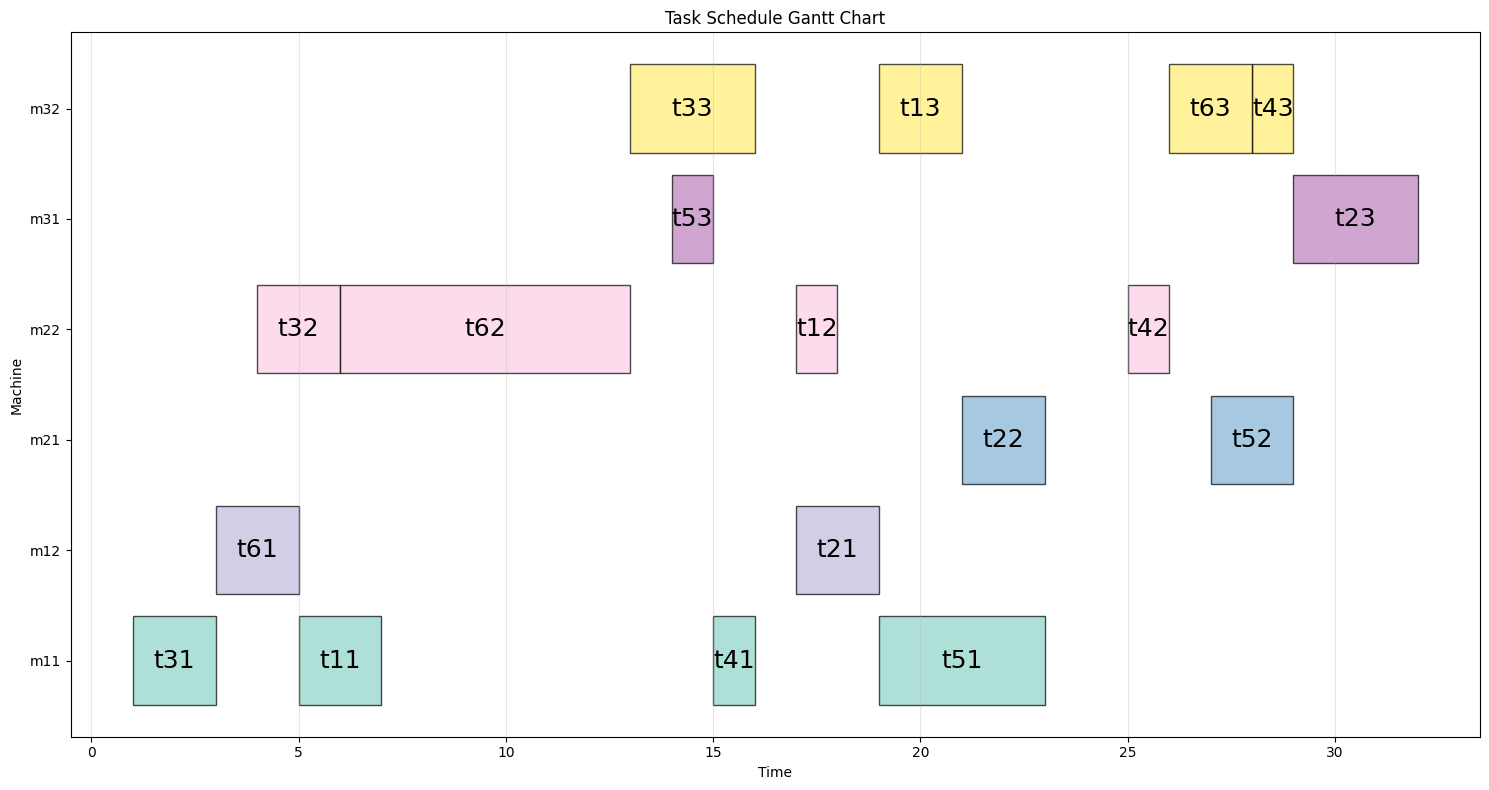

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def create_gantt_chart(transition_num, sorted_task_schedule, sort_ans, job_tasks, machine_processing_time, job):
    # マシンのユニークリストを取得
    machines = sorted(list(set(sorted_task_schedule.values())))
    machine_to_idx = {machine: idx for idx, machine in enumerate(machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = sorted_task_schedule[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # ジョブごとに異なる色を設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(job)))  # ジョブ数に応じたカラーマップ
    job_colors = {tuple(tasks): color for tasks, color in zip(job, colors)}  # ジョブと色を対応付け
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(machines)))
    machine_colors = dict(zip(machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスク名が属するジョブを見つけて色を設定
        task_color = None
        for tasks in job:
            if task in tasks:
                task_color = job_colors[tuple(tasks)]
                break
            
        if task_color is None:
            raise ValueError(f"Task {task} not found in job list")
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=18)
    
    # グラフの装飾
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# # タスクスケジュールの例
# fig, ax = create_gantt_chart(transition_num, sorted_task_schedule, sort_ans, job_tasks, machine_processing_time, job)

# コストスケジュールの例
fig, ax = create_gantt_chart(transition_num, sorted_cost_schedule, sort_ans, job_tasks, machine_processing_time, job)
plt.show()

# fig.savefig('./search/plots/gantt/1217/gantt1_1.png')

## パレートフロントのプロット

/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_90420/114755316.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feasible_data['SubH4_per_D'] = feasible_data['SubH4']
/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_90420/114755316.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feasible_data['SubH5_per_E'] = feasible_data['SubH5'] / feasible_data['E']


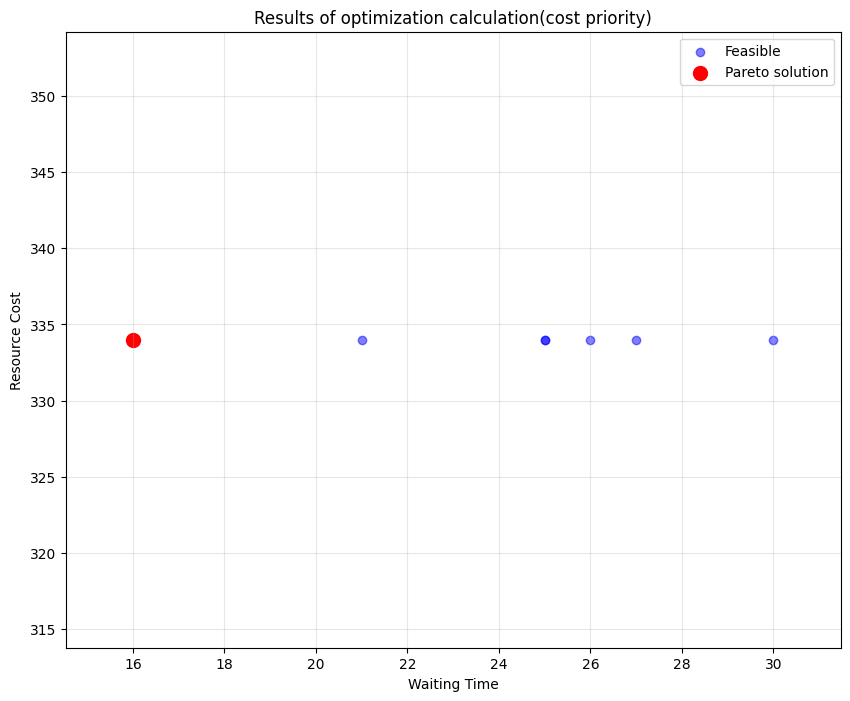


Total feasible solutions: 7
Number of Pareto optimal solutions: 1

Pareto optimal solutions details:
   SubH4_per_D  SubH5_per_E
1        334.0         16.0


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def is_pareto_efficient(costs):
    """
    パレート最適な点を見つける関数
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            dominated_points = np.all(costs >= c, axis=1) & np.any(costs > c, axis=1)
            is_efficient[dominated_points] = False
    return is_efficient

def plot_solutions_with_pareto(data_path, save_path=None):
    """
    解空間とパレートフロントを可視化する関数
    
    Parameters:
    -----------
    data_path : str
        CSVファイルのパス
    save_path : str, optional
        図を保存する場合のファイルパス
    """
    # データの読み込みと前処理
    data = pd.read_csv(data_path)
    feasible_data = data[data['feasible'] == True]
    
    # 比率の計算
    feasible_data['SubH4_per_D'] = feasible_data['SubH4']
    feasible_data['SubH5_per_E'] = feasible_data['SubH5'] / feasible_data['E']
    
    # コスト配列の作成
    costs = np.column_stack([
        feasible_data['SubH4_per_D'],
        feasible_data['SubH5_per_E']
    ])
    
    # パレートフロントの計算
    pareto_mask = is_pareto_efficient(costs)
    pareto_points = costs[pareto_mask]
    
    # プロットの作成
    plt.figure(figsize=(10, 8))
    
    # 全ての実行可能解をプロット
    plt.scatter(
        feasible_data['SubH5_per_E'],  # x軸をWaiting Timeに
        feasible_data['SubH4_per_D'],  # y軸をResource Costに
        c='blue',
        alpha=0.5,
        label='Feasible'
    )
    
    # パレート最適解のプロット
    plt.scatter(
        pareto_points[:, 1],  # x軸をWaiting Timeに
        pareto_points[:, 0],  # y軸をResource Costに
        c='red',
        s=100,
        label='Pareto solution'
    )
    
    # グラフの設定
    plt.ylabel('Resource Cost')
    plt.xlabel('Waiting Time')   
    # plt.title('Results of optimization calculation(task priority)')
    plt.title('Results of optimization calculation(cost priority)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 軸の範囲を少し広げる
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # パレート最適解の数と統計情報を出力
    print(f"\nTotal feasible solutions: {len(feasible_data)}")
    print(f"Number of Pareto optimal solutions: {sum(pareto_mask)}")
    
    return feasible_data[pareto_mask]

# 使用例
if __name__ == "__main__":
    file_path = "./search/job5/exam/optimization_results_job5_cost_5.csv"
    pareto_solutions = plot_solutions_with_pareto(file_path)
    
    # パレート最適解の詳細を表示
    print("\nPareto optimal solutions details:")
    print(pareto_solutions[['SubH4_per_D', 'SubH5_per_E']].to_string())

## task先行とcost先行の時の比較用plot

/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_90420/1032126779.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feasible_data['SubH4_per_D'] = feasible_data['SubH4']
/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_90420/1032126779.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feasible_data['SubH5_per_E'] = feasible_data['SubH5'] / feasible_data['E']


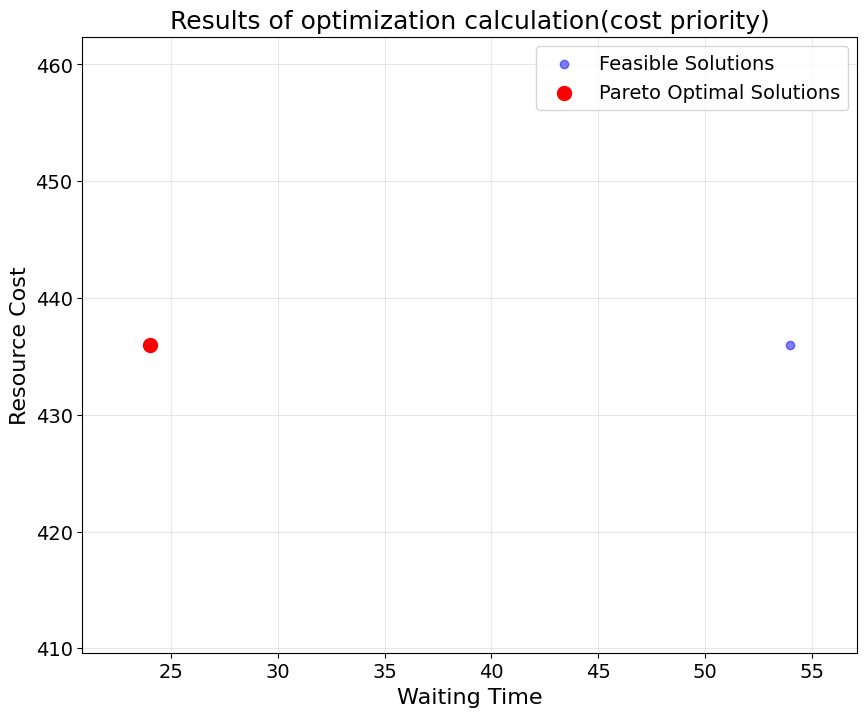


Total feasible solutions: 2
Number of Pareto optimal solutions: 1

Pareto optimal solutions details:
     SubH4_per_D  SubH5_per_E
425        436.0         24.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSVファイルのリスト
file_paths = [
    "./search/job7/exam/optimization_results_job7_cost_1.csv",
    "./search/job7/exam/optimization_results_job7_cost_2.csv",
    "./search/job7/exam/optimization_results_job7_cost_3.csv",
    "./search/job7/exam/optimization_results_job7_cost_4.csv",
    "./search/job7/exam/optimization_results_job7_cost_5.csv"
]

def is_pareto_efficient(costs):
    """
    パレート最適な点を見つける関数
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        dominated_points = np.all(costs >= c, axis=1) & np.any(costs > c, axis=1)
        is_efficient[dominated_points] = False
    return is_efficient

def plot_solutions_with_pareto(file_paths, save_path=None):
    """
    解空間とパレートフロントを可視化する関数
    
    Parameters:
    -----------
    file_paths : list
        CSVファイルのパスのリスト
    save_path : str, optional
        図を保存する場合のファイルパス
    """
    # すべてのデータを統合するリスト
    all_data = []

    # 各ファイルを読み込み
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        all_data.append(df)

    # データフレームを結合
    data = pd.concat(all_data, ignore_index=True)

    # Feasible な解をフィルタリング
    feasible_data = data[data['feasible'] == True]
    
    # 比率の計算
    feasible_data['SubH4_per_D'] = feasible_data['SubH4']
    feasible_data['SubH5_per_E'] = feasible_data['SubH5'] / feasible_data['E']
    
    # コスト配列の作成
    costs = np.column_stack([
        feasible_data['SubH4_per_D'],
        feasible_data['SubH5_per_E']
    ])
    
    # パレートフロントの計算
    pareto_mask = is_pareto_efficient(costs)
    pareto_points = costs[pareto_mask]
    
    # プロットの作成
    plt.figure(figsize=(10, 8))
    
    # 全ての実行可能解をプロット
    plt.scatter(
        feasible_data['SubH5_per_E'],  # x軸をWaiting Timeに
        feasible_data['SubH4_per_D'],  # y軸をResource Costに
        c='blue',
        alpha=0.5,
        label='Feasible Solutions'
    )
    
    # パレート最適解のプロット
    plt.scatter(
        pareto_points[:, 1],  # x軸をWaiting Timeに
        pareto_points[:, 0],  # y軸をResource Costに
        c='red',
        s=100,
        label='Pareto Optimal Solutions'
    )
    
    # グラフの設定
    plt.ylabel('Resource Cost', fontsize=16)
    plt.xlabel('Waiting Time', fontsize=16)
    plt.title('Results of optimization calculation(cost priority)', fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # 軸の範囲を調整
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # パレート最適解の数と統計情報を出力
    print(f"\nTotal feasible solutions: {len(feasible_data)}")
    print(f"Number of Pareto optimal solutions: {sum(pareto_mask)}")
    
    return feasible_data.iloc[pareto_mask]

# 使用例
if __name__ == "__main__":
    pareto_solutions = plot_solutions_with_pareto(file_paths)
    
    # パレート最適解の詳細を表示
    print("\nPareto optimal solutions details:")
    print(pareto_solutions[['SubH4_per_D', 'SubH5_per_E']].to_string())


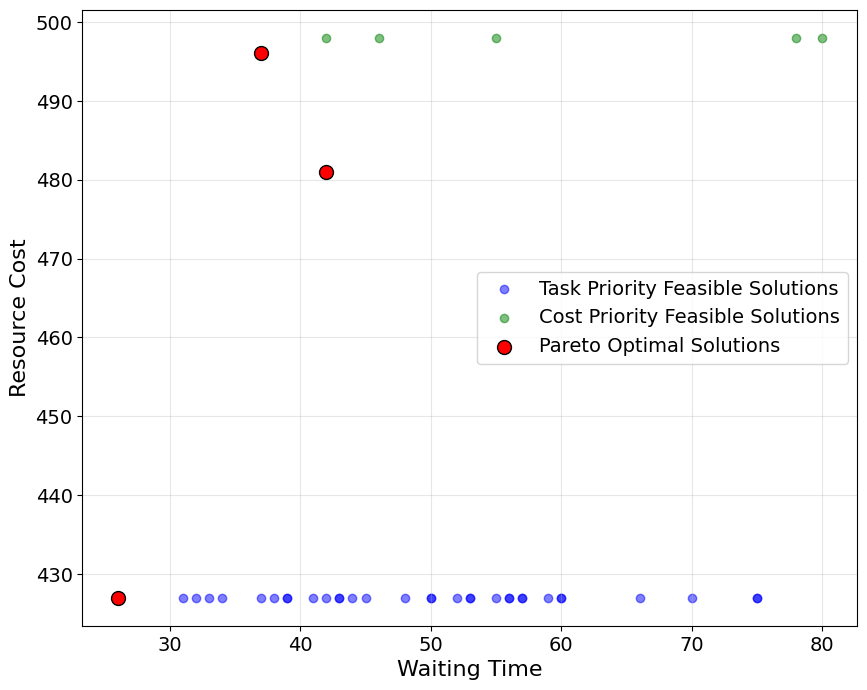


Task Priority Feasible Solutions: 33
Task Priority Pareto Solutions: 1

Cost Priority Feasible Solutions: 7
Cost Priority Pareto Solutions: 2

Task Priority Pareto Optimal Solutions:
    SubH4  SubH5_per_E
35  427.0         26.0

Cost Priority Pareto Optimal Solutions:
     SubH4  SubH5_per_E
58   481.0         42.0
177  496.0         37.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSVファイルのリスト
file_paths1 = [
    "./search/job6/exam/optimization_results_job6_task_1.csv",
    "./search/job6/exam/optimization_results_job6_task_2.csv",
    "./search/job6/exam/optimization_results_job6_task_3.csv",
    "./search/job6/exam/optimization_results_job6_task_4.csv",
    "./search/job6/exam/optimization_results_job6_task_5.csv"
]

file_paths2 = [
    "./search/job6/exam/optimization_results_job6_cost_1.csv",
    "./search/job6/exam/optimization_results_job6_cost_2.csv",
    "./search/job6/exam/optimization_results_job6_cost_3.csv",
    "./search/job6/exam/optimization_results_job6_cost_4.csv",
    "./search/job6/exam/optimization_results_job6_cost_5.csv"
]

def is_pareto_efficient(costs):
    """
    パレート最適な点を見つける関数
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        dominated_points = np.all(costs >= c, axis=1) & np.any(costs > c, axis=1)
        is_efficient[dominated_points] = False
    return is_efficient

def load_and_process_data(file_paths):
    """
    CSVファイルを読み込み、パレートフロントを計算する関数。
    """
    all_data = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        all_data.append(df)

    # 結合
    data = pd.concat(all_data, ignore_index=True)

    # 実行可能な解を抽出
    feasible_data = data[data['feasible'] == True].copy()
    
    # 指標を計算
    feasible_data['SubH5_per_E'] = np.where(
        feasible_data['E'] != 0, 
        feasible_data['SubH5'] / feasible_data['E'], 
        np.nan
    )
    
    # NaN を除去
    feasible_data = feasible_data.dropna(subset=['SubH5_per_E'])
    
    # コスト配列
    costs = feasible_data[['SubH4', 'SubH5_per_E']].to_numpy()
    
    # パレートフロントを計算
    pareto_mask = is_pareto_efficient(costs)
    
    return feasible_data, pareto_mask

def plot_dual_solutions(file_paths1, file_paths2, save_path=None):
    """
    2種類の最適化結果（タスク優先 & コスト優先）を可視化する。
    """
    # データの処理
    feasible_data_task, pareto_mask_task = load_and_process_data(file_paths1)
    feasible_data_cost, pareto_mask_cost = load_and_process_data(file_paths2)

    # パレートフロントの取得
    pareto_points_task = feasible_data_task.iloc[pareto_mask_task]
    pareto_points_cost = feasible_data_cost.iloc[pareto_mask_cost]

    # プロットの作成
    plt.figure(figsize=(10, 8))

    # タスク優先 (青)
    plt.scatter(
        feasible_data_task['SubH5_per_E'], 
        feasible_data_task['SubH4'], 
        c='blue', alpha=0.5, label='Task Priority Feasible Solutions'
    )

    # コスト優先 (緑)
    plt.scatter(
        feasible_data_cost['SubH5_per_E'], 
        feasible_data_cost['SubH4'], 
        c='green', alpha=0.5, label='Cost Priority Feasible Solutions'
    )

    # パレート最適解 (赤)
    plt.scatter(
        pareto_points_task['SubH5_per_E'], 
        pareto_points_task['SubH4'], 
        c='red', s=100, edgecolors='black', label='Pareto Optimal Solutions'
    )

    plt.scatter(
        pareto_points_cost['SubH5_per_E'], 
        pareto_points_cost['SubH4'], 
        c='red', s=100, edgecolors='black'
    )

    # 軸ラベル・タイトル（フォントサイズを大きく）
    plt.ylabel('Resource Cost', fontsize=16)
    plt.xlabel('Waiting Time', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # 軸範囲の計算（両データセットを考慮）
    x_min = min(feasible_data_task['SubH5_per_E'].min(), feasible_data_cost['SubH5_per_E'].min())
    x_max = max(feasible_data_task['SubH5_per_E'].max(), feasible_data_cost['SubH5_per_E'].max())
    y_min = min(feasible_data_task['SubH4'].min(), feasible_data_cost['SubH4'].min())
    y_max = max(feasible_data_task['SubH4'].max(), feasible_data_cost['SubH4'].max())

    plt.xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))

    # 保存オプション
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

    # 統計情報の出力
    print(f"\nTask Priority Feasible Solutions: {len(feasible_data_task)}")
    print(f"Task Priority Pareto Solutions: {sum(pareto_mask_task)}")

    print(f"\nCost Priority Feasible Solutions: {len(feasible_data_cost)}")
    print(f"Cost Priority Pareto Solutions: {sum(pareto_mask_cost)}")

    return pareto_points_task, pareto_points_cost

# 使用例
if __name__ == "__main__":
    pareto_solutions_task, pareto_solutions_cost = plot_dual_solutions(file_paths1, file_paths2)

    print("\nTask Priority Pareto Optimal Solutions:")
    print(pareto_solutions_task[['SubH4', 'SubH5_per_E']].to_string())

    print("\nCost Priority Pareto Optimal Solutions:")
    print(pareto_solutions_cost[['SubH4', 'SubH5_per_E']].to_string())

